# Libraries to Install
- Matplotlib
- Pandas
- Google API Client
- NLTK (with corpus)

*Not a library but Perspective API is needed for this to work*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Exploring the Sample Dataset
Reads the sample data from csv file and puts it into the dataframe df

In [3]:
df = pd.read_csv('Sample_labaled_data.csv')
df

,Unnamed: 0,id,comment_text,toxic
0,5,0001ea8717f6de06,Thank you for understanding I think very highl...,no
1,7,000247e83dcc1211,Dear god this site is horrible,no
2,11,0002f87b16116a7f,Somebody will invariably try to add Religion ...,no
3,13,0003e1cccfd5a40a,It says it right there that it IS a type The...,no
4,14,00059ace3e3e9a53,Before adding a new product to the list mak...,no
...,...,...,...,...
55247,153147,fff83b80284d8440,Consensus for ruining Wikipedia I think that c...,no
55248,153149,fff8f521a7dbcd47,shut down the mexican border withought looking...,no
55249,153150,fff8f64043129fa2,Jerome I see you never got around to this… I’m...,no
55250,153151,fff9d70fe0722906,Lucky bastard httpwikimediafoundationorgwikiP...,no


Creates new dataframes selected comments that are toxic and putting them into df_toxic and the non-toxic comments to df_non_toxic

In [4]:
df_toxic = df[df['toxic'] == 'yes']
df_non_toxic = df[df['toxic'] == 'no']

Creates a copy of df_toxic so all comments are lower-case, utilizies stopwords from NLTK to remove redudant words from the comments, and finally get the list of the most common words in toxic comments

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
toxic_copy = df_toxic.copy(deep = True)
toxic_copy['comment_text'] = toxic_copy['comment_text'].str.lower()
toxic_copy['comment_text'] = toxic_copy['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
from collections import Counter
common_words = Counter(" ".join(toxic_copy["comment_text"]).split()).most_common(10)
common_words

[('nigger', 1467),
 ('faggot', 1049),
 ('boob', 1001),
 ('poop', 987),
 ('hate', 955),
 ('gay', 941),
 ('youi', 886),
 ('niggers', 884),
 ('penis', 624),
 ('stupid', 618)]

Graphs the most common words in a bar graph to see whether or not I can formulate a hypothesis based on this data

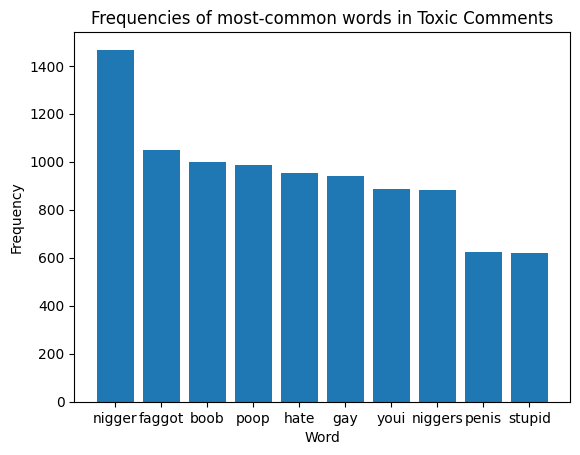

In [6]:
x = []
y = []

for i in range(len(common_words)):
    x.append(common_words[i][0])
    y.append(common_words[i][1])
plt.bar(x, y)
plt.xlabel('Word')
plt.ylabel('Frequency')
_ = plt.title('Frequencies of most-common words in Toxic Comments')

# Getting the Threshold
Getting the treshold involves getting samples from comments labeled toxic and non-toxic; this means we will get samples from the toxic dataframe and non-toxic dataframe (I chose 15 from each). From there we will see where the minimum toxic score is and the max non-toxic score is to determine the threshold.

In [7]:
from googleapiclient import discovery
import json

API_KEY = ''

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

toxic = df_toxic.sample(15)
toxic.reset_index(inplace = True)
toxic = toxic.drop(columns = 'index')
toxic_scores = []

non_toxic = df_non_toxic.sample(15)
non_toxic.reset_index(inplace = True)
non_toxic = non_toxic.drop(columns = 'index')
non_toxic_scores = []

for i in range(len(toxic)):
    analyze_request = {
        'comment': { 'text': toxic['comment_text'].iloc[i] },
        'requestedAttributes': {'TOXICITY': {}}
    }
    response = client.comments().analyze(body=analyze_request).execute()
    toxic_scores.append(response['attributeScores']['TOXICITY']['summaryScore']['value'])


for i in range(len(non_toxic)):
    analyze_request = {
        'comment': { 'text': non_toxic['comment_text'].iloc[i] },
        'requestedAttributes': {'TOXICITY': {}}
    }
    response = client.comments().analyze(body=analyze_request).execute()
    non_toxic_scores.append(response['attributeScores']['TOXICITY']['summaryScore']['value'])


I try and see whether the minimum score for toxic and maximum score for non toxic comments are about the same; however, in this case they aren't.

In [8]:
print('Minimum score for Toxic: ' + str(min(toxic_scores)))
print('Maximum score for Non-Toxic: ' + str(max(non_toxic_scores)))

Minimum score for Toxic: 0.45090583
Maximum score for Non-Toxic: 0.60311776


# Determining the Threshold
With the sample data that I used, I think using the value of maximum score for non-toxic should be the threshold of what is deemed toxic; therefore, the threshold is .60311776

In [9]:
threshold = max(non_toxic_scores)

# Hypothesis
If the comment is long (more than 10 words), and if toxicity is near the end of text, then PerspectiveAPI will not mark the comment toxic even if it contains a string that it previous deemed toxic. PerspectiveAPI will mark the shorter (10 or less words) as toxic if obscenities are detected. 

# Design / Testing Methods

To prove my hypothesis, I need to figure out the amount of words (comment length) in the comment; additionally, I need to modify the comment to see if longer strings are incorrectly classified. 

1. Create a copy of df_toxic
2. Create a new column called 'comment_length' using split() on each element of the dataframe
3. Select only the comments that have less than 10 words and put them into a dataframe called tox and get 30 random samples from tox
4. Find the initial score of the comment using Perspective API and put in a new column called initial_comment_score
5. Add a string with positive words in front of the common text and find the score (puts in new column called modified_comment_score)
6. See if the classification of the comment changes by comparing the modified_comment_score with the threshold calculated in variable 'threshold'


# 1. Create copy of df_toxic

For my standard practices, anytime I create a copy of a new dataframe, I like to use reset_index() so I guarantee my for loops work. 

In [20]:
tox = df_toxic.copy(deep = True)
tox.reset_index(inplace = True)
tox = tox.drop(columns = 'index')
tox

,Unnamed: 0,id,comment_text,toxic
0,21,00091c35fa9d0465,Arabs are committing genocide in Iraq but no ...,yes
1,76,001d739c97bc2ae4,How dare you vandalize that page about the HMS...,yes
2,81,001eff4007dbb65b,No he is an arrogant self serving immature idi...,yes
3,219,005f47397e07e12f,Eek but shes cute in an earthy kind of way Can...,yes
4,258,0071940212267fea,Well it sucks to have a university to be nickn...,yes
...,...,...,...,...
3838,152757,ff4db4dfa3292099,dude you are all bitches you sit there and pol...,yes
3839,152779,ff57f544aee14cd8,you might mention it was all your fault our ...,yes
3840,152836,ff6fce734d8f8c8b,THIS IS TOM YA SOOOO AWESOME LOLOLOLOLOLOLOLOL...,yes
3841,152908,ff91c3d8a3e34398,NIGEL IS A CRAZY IDIOT,yes


# 2. Create a new column called 'comment_length' using split() on each element of the dataframe


In [21]:
length = []
temp = ""
for i in range(len(tox)):
    temp = tox['comment_text'].iloc[i]
    length.append(len(temp.split()))
    temp = ""
tox['comment_length'] = length
tox

,Unnamed: 0,id,comment_text,toxic,comment_length
0,21,00091c35fa9d0465,Arabs are committing genocide in Iraq but no ...,yes,17
1,76,001d739c97bc2ae4,How dare you vandalize that page about the HMS...,yes,14
2,81,001eff4007dbb65b,No he is an arrogant self serving immature idi...,yes,12
3,219,005f47397e07e12f,Eek but shes cute in an earthy kind of way Can...,yes,22
4,258,0071940212267fea,Well it sucks to have a university to be nickn...,yes,22
...,...,...,...,...,...
3838,152757,ff4db4dfa3292099,dude you are all bitches you sit there and pol...,yes,36
3839,152779,ff57f544aee14cd8,you might mention it was all your fault our ...,yes,14
3840,152836,ff6fce734d8f8c8b,THIS IS TOM YA SOOOO AWESOME LOLOLOLOLOLOLOLOL...,yes,26
3841,152908,ff91c3d8a3e34398,NIGEL IS A CRAZY IDIOT,yes,5


# 3. Select only the comments that have less than 10 words and put them into a dataframe called tox and get 30 random samples from tox

In [22]:
tox = tox[tox['comment_length'] <= 10]

tox = tox.sample(30)
tox.reset_index(inplace = True)
tox = tox.drop(columns = 'index')
tox

,Unnamed: 0,id,comment_text,toxic,comment_length
0,47401,4ea24a2ad207d7e5,I think you need to grow some balls,yes,8
1,108146,b479329ab8989925,Youre an idiot,yes,3
2,117397,c3f42a0d7c1762c7,Dude like era sucks,yes,4
3,132472,dd5623eed76a2f0f,And apparently youre a pile of horseshite sic,yes,8
4,44439,49afcdbabb3d74fe,Vandalism Enough of the wizard and gay porn v...,yes,9
5,6217,0a6f266436c60a69,WTF F YOU BASTARDS,yes,4
6,55790,5cc9a60896e0691e,You lying bastard Brought to you by Joe Wilson,yes,9
7,36711,3cf2789290384003,STFU SHUT THE FCK UP,yes,5
8,98748,a4c38c17eeec38e8,shut up and go away,yes,5
9,62772,68863b83a7a038be,i like donkey nipples,yes,4


# 4. Find the initial score of the comment using Perspective API and put in a new column called initial_comment_score


In [23]:
initial_score = []
for i in range(len(tox)):
    analyze_request = {
        'comment': { 'text': tox['comment_text'].iloc[i] },
        'requestedAttributes': {'TOXICITY': {}}
    }
    response = client.comments().analyze(body=analyze_request).execute()
    initial_score.append(response['attributeScores']['TOXICITY']['summaryScore']['value'])
tox['initial_comment_score'] = initial_score
tox

,Unnamed: 0,id,comment_text,toxic,comment_length,initial_comment_score
0,47401,4ea24a2ad207d7e5,I think you need to grow some balls,yes,8,0.720280
1,108146,b479329ab8989925,Youre an idiot,yes,3,0.920998
2,117397,c3f42a0d7c1762c7,Dude like era sucks,yes,4,0.725297
3,132472,dd5623eed76a2f0f,And apparently youre a pile of horseshite sic,yes,8,0.799855
4,44439,49afcdbabb3d74fe,Vandalism Enough of the wizard and gay porn v...,yes,9,0.770145
5,6217,0a6f266436c60a69,WTF F YOU BASTARDS,yes,4,0.898824
6,55790,5cc9a60896e0691e,You lying bastard Brought to you by Joe Wilson,yes,9,0.854047
7,36711,3cf2789290384003,STFU SHUT THE FCK UP,yes,5,0.787120
8,98748,a4c38c17eeec38e8,shut up and go away,yes,5,0.710546
9,62772,68863b83a7a038be,i like donkey nipples,yes,4,0.628937


# 5. Add a string with positive words in front of the common text and find the score (puts in new column called modified_comment_score)

In [25]:
positive_str = 'you made my day bright kind person Im encouraged after reading this amazing stuff im so happy and glad that you are amazing thank you'

strs = []
for i in range(len(tox)):
    strs.append(positive_str + tox['comment_text'].iloc[i])
tox['modified_comment'] = strs
tox

,Unnamed: 0,id,comment_text,toxic,comment_length,initial_comment_score,modified_comment
0,47401,4ea24a2ad207d7e5,I think you need to grow some balls,yes,8,0.720280,you made my day bright kind person Im encourag...
1,108146,b479329ab8989925,Youre an idiot,yes,3,0.920998,you made my day bright kind person Im encourag...
2,117397,c3f42a0d7c1762c7,Dude like era sucks,yes,4,0.725297,you made my day bright kind person Im encourag...
3,132472,dd5623eed76a2f0f,And apparently youre a pile of horseshite sic,yes,8,0.799855,you made my day bright kind person Im encourag...
4,44439,49afcdbabb3d74fe,Vandalism Enough of the wizard and gay porn v...,yes,9,0.770145,you made my day bright kind person Im encourag...
5,6217,0a6f266436c60a69,WTF F YOU BASTARDS,yes,4,0.898824,you made my day bright kind person Im encourag...
6,55790,5cc9a60896e0691e,You lying bastard Brought to you by Joe Wilson,yes,9,0.854047,you made my day bright kind person Im encourag...
7,36711,3cf2789290384003,STFU SHUT THE FCK UP,yes,5,0.787120,you made my day bright kind person Im encourag...
8,98748,a4c38c17eeec38e8,shut up and go away,yes,5,0.710546,you made my day bright kind person Im encourag...
9,62772,68863b83a7a038be,i like donkey nipples,yes,4,0.628937,you made my day bright kind person Im encourag...


In [26]:
modified_score = []
for i in range(len(tox)):
    analyze_request = {
        'comment': { 'text': (positive_str + tox['comment_text'].iloc[i]) },
        'requestedAttributes': {'TOXICITY': {}}
    }
    response = client.comments().analyze(body=analyze_request).execute()
    modified_score.append(response['attributeScores']['TOXICITY']['summaryScore']['value'])
tox['modified_comment_score'] = modified_score
tox

,Unnamed: 0,id,comment_text,toxic,comment_length,initial_comment_score,modified_comment,modified_comment_score
0,47401,4ea24a2ad207d7e5,I think you need to grow some balls,yes,8,0.720280,you made my day bright kind person Im encourag...,0.637829
1,108146,b479329ab8989925,Youre an idiot,yes,3,0.920998,you made my day bright kind person Im encourag...,0.787120
2,117397,c3f42a0d7c1762c7,Dude like era sucks,yes,4,0.725297,you made my day bright kind person Im encourag...,0.521400
3,132472,dd5623eed76a2f0f,And apparently youre a pile of horseshite sic,yes,8,0.799855,you made my day bright kind person Im encourag...,0.592154
4,44439,49afcdbabb3d74fe,Vandalism Enough of the wizard and gay porn v...,yes,9,0.770145,you made my day bright kind person Im encourag...,0.553210
5,6217,0a6f266436c60a69,WTF F YOU BASTARDS,yes,4,0.898824,you made my day bright kind person Im encourag...,0.761980
6,55790,5cc9a60896e0691e,You lying bastard Brought to you by Joe Wilson,yes,9,0.854047,you made my day bright kind person Im encourag...,0.640770
7,36711,3cf2789290384003,STFU SHUT THE FCK UP,yes,5,0.787120,you made my day bright kind person Im encourag...,0.767545
8,98748,a4c38c17eeec38e8,shut up and go away,yes,5,0.710546,you made my day bright kind person Im encourag...,0.584095
9,62772,68863b83a7a038be,i like donkey nipples,yes,4,0.628937,you made my day bright kind person Im encourag...,0.612239


# 6. See if the classification of the comment changes by comparing the modified_comment_score with the threshold calculated in variable 'threshold'

In [27]:
new_classified = []
for i in range(len(tox)):
    if tox['modified_comment_score'].iloc[i] <= threshold:
        new_classified.append('no')
    else:
        new_classified.append('yes')
tox['modified_toxic'] = new_classified
tox

,Unnamed: 0,id,comment_text,toxic,comment_length,initial_comment_score,modified_comment,modified_comment_score,modified_toxic
0,47401,4ea24a2ad207d7e5,I think you need to grow some balls,yes,8,0.720280,you made my day bright kind person Im encourag...,0.637829,yes
1,108146,b479329ab8989925,Youre an idiot,yes,3,0.920998,you made my day bright kind person Im encourag...,0.787120,yes
2,117397,c3f42a0d7c1762c7,Dude like era sucks,yes,4,0.725297,you made my day bright kind person Im encourag...,0.521400,no
3,132472,dd5623eed76a2f0f,And apparently youre a pile of horseshite sic,yes,8,0.799855,you made my day bright kind person Im encourag...,0.592154,no
4,44439,49afcdbabb3d74fe,Vandalism Enough of the wizard and gay porn v...,yes,9,0.770145,you made my day bright kind person Im encourag...,0.553210,no
5,6217,0a6f266436c60a69,WTF F YOU BASTARDS,yes,4,0.898824,you made my day bright kind person Im encourag...,0.761980,yes
6,55790,5cc9a60896e0691e,You lying bastard Brought to you by Joe Wilson,yes,9,0.854047,you made my day bright kind person Im encourag...,0.640770,yes
7,36711,3cf2789290384003,STFU SHUT THE FCK UP,yes,5,0.787120,you made my day bright kind person Im encourag...,0.767545,yes
8,98748,a4c38c17eeec38e8,shut up and go away,yes,5,0.710546,you made my day bright kind person Im encourag...,0.584095,no
9,62772,68863b83a7a038be,i like donkey nipples,yes,4,0.628937,you made my day bright kind person Im encourag...,0.612239,yes


In [28]:
tox['modified_toxic'].value_counts()

no     17
yes    13
Name: modified_toxic, dtype: int64

# Results / Conclusion

My hypothesis was not entirely correct, but it had some resemeblance to the data. More than half the sampled comments changed from toxic to non-toxic after adding positive words before them. However, 13 of the 30 remained the same even after adding a 25 positive word string in front of the toxic comments. I think if I had more data points, there would be more of a clear picture on if my hypothesis was correct or not.

What suprised me about my findings is that one of the scores actually increased after adding my custom string of positive words. Additionally, I though that the comments with the same amount of starting words would see their toxicity decrease the same amount, but that was not the case. I was suprised with how much the scores changed: some of them barely changed and others went down by 0.2. 

A theory on why I got the results I have is that certain words or phrases are weighted more toxic than the others. Some words are deemed super toxic as PerspectiveAPI gave comments with that word an initial score of 0.9 and above. Because of the initial weights, even if I added a lot of positive words, it would be harder for the score to go below the threshold.

Puts the text given to Perspective API (original and modified) into a csv file along with their toxicity scores

In [33]:
tox[['comment_text', 'initial_comment_score', 'modified_comment', 'modified_comment_score']].to_csv('commentandscores.csv')